In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
np.set_printoptions(precision=3)

# Load chaosNLI annotations and predictions from several RoBERTa models

In [2]:
from data_utils import load_data, subsample_annotations
from analysis_utils import generate_figure1, generate_table1, generate_figure2_and_table2, mle

base_config = {
    "datasets": ["snli"],  # loads annotations and predictions from the chaosNLI-SNLI source dataset
    "splits": ["test","dev"],  # combines predictions on the 5k test and 5k dev set, see readme.md
    "model_name": "roberta-base"
}

# ChaosNLI annotations and predictions are sorted on uid
annotations_dict, roberta0_probs = load_data(**{**base_config, "model_seed": 0})
_, roberta1_probs = load_data(**{**base_config, "model_seed": 1})
_, roberta2_probs = load_data(**{**base_config, "model_seed": 2})
_, roberta0_ts_probs = load_data(**{**base_config, "model_seed": 0, "temp": 2})
_, roberta1_ts_probs = load_data(**{**base_config, "model_seed": 1, "temp": 2})
_, roberta2_ts_probs = load_data(**{**base_config, "model_seed": 2, "temp": 2})

print("n_instances, n_classes, mass", roberta0_probs.shape, roberta0_probs.sum(-1)[1])
original_annotations = annotations_dict["original"]
print("n_instances, n_classes, n_votes:", original_annotations.shape, original_annotations.sum(-1)[0])
chaosnli_annotations = annotations_dict["chaosnli"]
print("n_instances, n_classes, n_votes:", chaosnli_annotations.shape, chaosnli_annotations.sum(-1)[0])


n_instances, n_classes, mass (1514, 3) 1.0
n_instances, n_classes, n_votes: (1514, 3) 5
n_instances, n_classes, n_votes: (1514, 3) 100


## Generate Figure 1

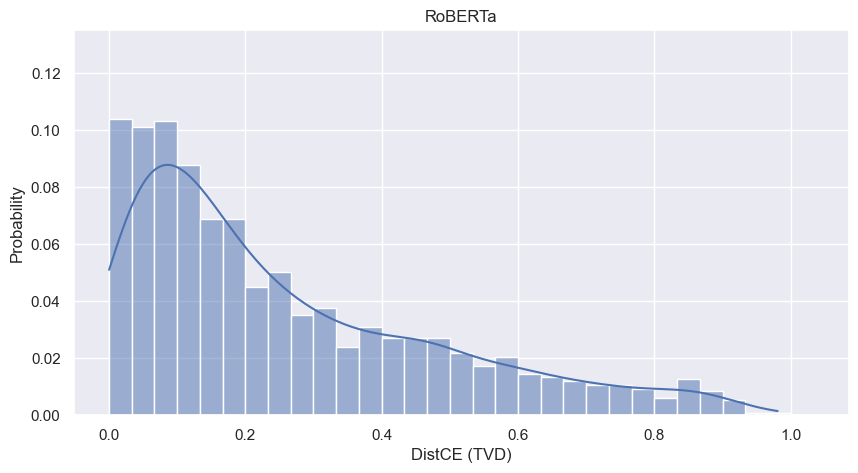

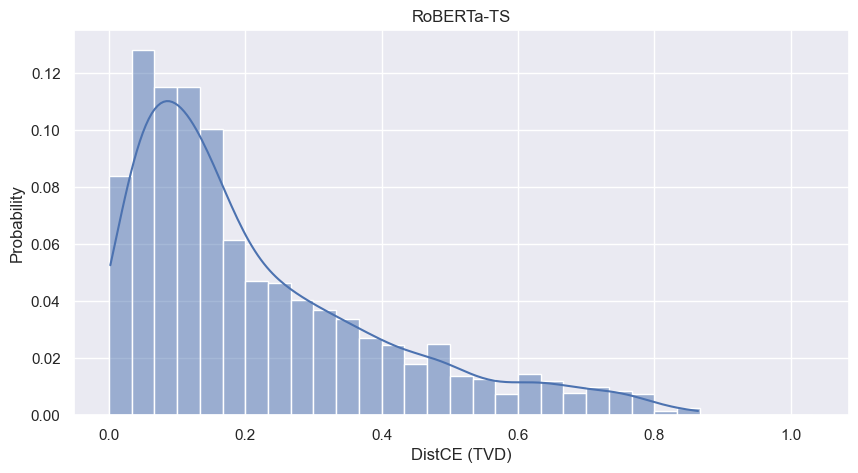

In [3]:
generate_figure1(roberta0_probs, "RoBERTa", chaosnli_annotations, n_bins=30)
generate_figure1(roberta0_ts_probs, "RoBERTa-TS", chaosnli_annotations, n_bins=30)

## Generate Table 1

In [4]:
t1_classifier_names = [
    f"RoBERTa",
    f"RoBERTa1",
    f"RoBERTa2",
    f"RoBERTa-TS",
    f"RoBERTa1-TS",
    f"RoBERTa2-TS",
    f"Oracle",
]
t1_classifiers = np.stack(
    [
        roberta0_probs,
        roberta1_probs,
        roberta2_probs,
        roberta0_ts_probs,
        roberta1_ts_probs,
        roberta2_ts_probs,
        mle(chaosnli_annotations),
    ],
    axis=0,
)
generate_table1(t1_classifiers, t1_classifier_names, chaosnli_annotations)

['RoBERTa', 'RoBERTa1', 'RoBERTa2', 'RoBERTa-TS', 'RoBERTa1-TS', 'RoBERTa2-TS', 'Oracle']
Acc [0.74  0.736 0.752 0.74  0.736 0.752 1.   ]
ECE [0.147 0.119 0.141 0.036 0.03  0.02  0.245]
RankCS [0.625 0.596 0.627 0.625 0.596 0.627 1.   ]
EntCE [0.31  0.273 0.314 0.208 0.236 0.198 0.   ]
DistCE [0.259 0.249 0.261 0.217 0.222 0.214 0.   ]


## Generate Figure 2 and Table 2

['H1', 'H2', 'RoBERTa', 'RoBERTa-TS']
ECE scores [0.16  0.163 0.147 0.036]
DistCE scores [0.072 0.073 0.259 0.217]
kl(H1, H2):0.0047
kl(H1, vanilla): 0.64
kl(H1, TS): 0.56


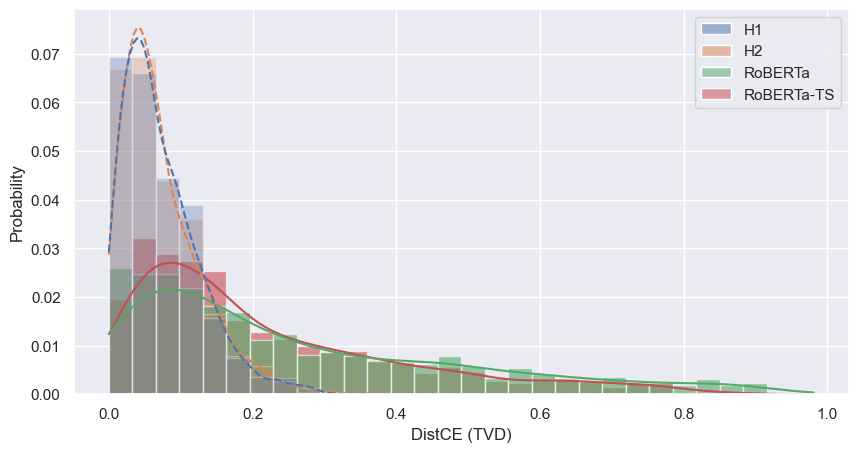

In [5]:
# We noticed that we lost track of the random seed used for fig 2 in the paper.
# While not identical, the results are similar: the trend is confirmed and so are the findings
votes_per_subsample = 20
subsamples = subsample_annotations(
    chaosnli_annotations, votes_per_subsample, np.random.default_rng(1)
)
t2_classifier_names = [f"H1", f"H2", f"RoBERTa", f"RoBERTa-TS"]
t2_classifiers = np.stack(
    [
        mle(subsamples[0]), # select the first random subsample containing 20 annotations per instance
        mle(subsamples[1]),
        roberta0_probs,
        roberta0_ts_probs,
    ],
    axis=0,
)
generate_figure2_and_table2(
    t2_classifiers, t2_classifier_names, chaosnli_annotations, n_bins=30, div="kl"
)

## Bonus figure
Based on feedback we received after publication, here we perform a final analysis where we evaluate all classifiers (H1, H2, RoBERTa and RoBERTa-TS) against the remaining 60 annotations after sampling 20 votes without replacement twice to obtain H1 and H2. We observe a similar trend.

['H1', 'H2', 'RoBERTa', 'RoBERTa-TS']
ECE scores [0.142 0.142 0.151 0.042]
DistCE scores [0.092 0.094 0.261 0.219]
kl(H1, H2):0.0084
kl(H1, vanilla): 0.48
kl(H1, TS): 0.38


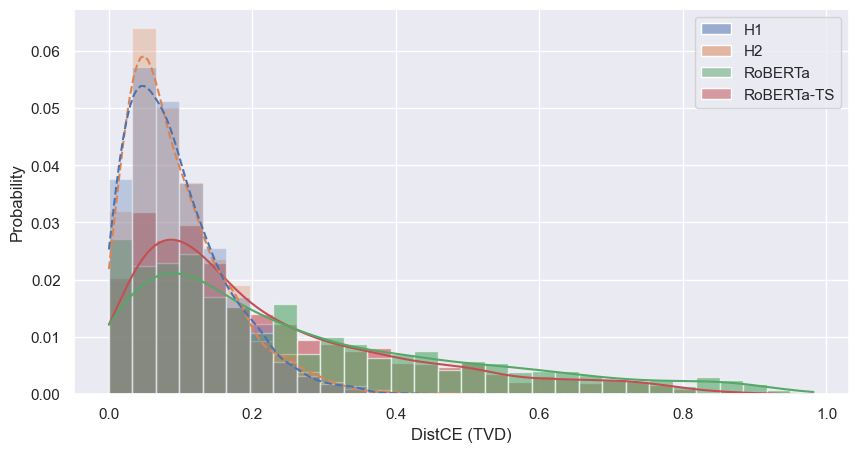

In [6]:
votes_per_subsample = 20
subsamples = subsample_annotations(
    chaosnli_annotations, votes_per_subsample, np.random.default_rng(1)
)
remaining_annotations = subsamples[2] + subsamples[3] + subsamples[4]
t2_classifier_names = [f"H1", f"H2", f"RoBERTa", f"RoBERTa-TS"]
t2_classifiers = np.stack(
    [
        mle(subsamples[0]), # select the first random subsample containing 20 annotations per instance
        mle(subsamples[1]),
        roberta0_probs,
        roberta0_ts_probs,
    ],
    axis=0,
)
generate_figure2_and_table2(
    t2_classifiers, t2_classifier_names, remaining_annotations, n_bins=30, div="kl"
)